## Problem 1: Face time (35 points)

In this problem, we will implement a "shoestring" version of [this amazing fake face generator](https://www.nytimes.com/interactive/2020/11/21/science/artificial-intelligence-fake-people-faces.html), using a variational autoencoder (VAE). Building a generator like the one featured in the article can take a tremendous amount of computational resources, time, and parameter tuning. In this problem we will build a basic version to illustrate the main concepts, and help you to become more famililar with VAEs.  Here is an outline of the process that we'll step you through:

### Problem outline:

* Load data
* Create face groups based on attributes
* Construct the VAE
* Define the loss function and train the VAE (Problem 1.1)
* Encode and reconstruct faces (Problem 1.2)
* Visualize the latent space (Problem 1.3)
* Morph between faces (Problem 1.4)
* Shift attributes of faces (Problem 1.5)
* Generate new faces (Problem 1.6)
* Analyze the effect of the scaling factor in the loss function (Problem 1.7, optional)

In the next cell we load the packages that we'll need. If you don't have one or more of these, you can install them with `!pip install <package_name>` in the cell, or outside the notebook
with `conda install -c conda-forge <package_name>`

In [1]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm

import tensorflow as tf

from tensorflow import keras
from keras import layers, Input, Model, ops

import seaborn as sns
import pickle

### Loading the data

[Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/) (LFW) is a database of face photographs. The images are placed in the folder lfw-deepfunneled. lfw_attributes.txt is a document including a set of attributes associated for each image, such as 'Male', 'Smile', 'Bold', etc. All the features are numerical and large positive values indicate that the keywords well describe the photo; large negative values indicate that the keywords don't fit the photo.

For this problem, we will keep only the middle parts of the photos to avoid complex backgrounds.

Download the data from the cloud at these URLs:

https://sds365.s3.amazonaws.com/lfw/lfw-deepfunneled.zip
<br>
https://sds365.s3.amazonaws.com/lfw/lfw_attributes.txt

Once you have the data, unzip it, and place it in a directory that we will call "YOUR_PATH" below.
  
Run all the cells in this section to load the data.

Note: Please write down the entire path instead of using something like '~/Desktop/datasets/' to avoid unnecessary compiling errors. Also, if you choose to use Colab to do your homework. We need to download the data into the same directory as your code. You may also need

"from google.colab import drive"

"drive.mount('/content/drive')"

to enable using paths in Google Drive before starting your code below. But personally, I would suggest using jupyter notebook to run the code locally instead of using Google Colab since the latter may take longer time.

In [2]:
# Change these path names to correspond with your directory
# DATASET_PATH ="/YOUR_PATH/lfw-deepfunneled/"
# ATTRIBUTES_PATH = "/YOUR_PATH/lfw_attributes.txt"

DATA_PATH = "A1_compiled_cutouts_3arcsec_30mas.pkl"

In [3]:
# Load data
# rows: ID, image info, redshift
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f) 

/var/folders/_7/2zx358892jg3bmslfmn_820w0000gn/T/ipykernel_85314/150499598.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


In [4]:
# IDs
ids = data[0]

# images
images = np.stack(data[1]).astype("float32")
images = images / np.max(images)  # normalize

The variable `data` has all the face images and the variable `attrs` has all the attributes. The 8-bit RGB values are converted to values between 0 and 1 for modeling and plotting purposes.

In [5]:
attrs = pd.read_csv("cosmos_cut.csv", sep=",")

df_images = pd.DataFrame({'id': ids})
merged = pd.merge(df_images, attrs, on="id", how="inner") # only when IDs match

images = images[merged.index]
redshifts = merged["z"].to_numpy(dtype="float32")

### Constructing the encoder

Recall that the encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.


In [6]:
LATENT_SPACE_SIZE = 100

The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean and variance, so that the parameters of the encoder network can be trained.


In [84]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    noise = backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * noise

In [94]:
# two branch encoder for images and redshifts

# image branch
image_input = layers.Input(shape=(100, 100, 4))

x_encoder = layers.Conv2D(64, (5,5), activation='relu', padding='same')(image_input)
x_encoder = layers.MaxPooling2D((2,2))(x_encoder)

x_encoder = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x_encoder)
x_encoder = layers.MaxPooling2D((2,2))(x_encoder)

x_encoder = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x_encoder)
x_encoder = layers.MaxPooling2D((2,2))(x_encoder)

x_encoder = layers.Flatten()(x_encoder)

# redshift branch (scalar)
redshift_input = layers.Input(shape=(1,), name='redshift_input')
redshift_dense = layers.Dense(16, activation='relu')(redshift_input)  # projection

# merge image and redshift
merged = layers.Concatenate()([x_encoder, redshift_dense])

distribution_mean = layers.Dense(LATENT_SPACE_SIZE, name='variational_mean')(merged)
distribution_variance = layers.Dense(LATENT_SPACE_SIZE, name='variational_log_variance')(merged)

# Sampling function
latent_encoding = layers.Lambda(sample_latent_features, 
                                output_shape=(LATENT_SPACE_SIZE,))([distribution_mean, distribution_variance])

# Encoder model
encoder_model = Model(inputs=[image_input, redshift_input], outputs=latent_encoding)
encoder_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 100, 100,  │      6,464 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 50, 50,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 50, 50,    │     36,928 │ max_pooling2d_30… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 25, 25,    │          0 │ conv2d_40[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 25, 25,    │     18,464 │ max_pooling2d_31… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 12, 12,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 4608)      │          0 │ max_pooling2d_32… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 16)        │         32 │ redshift_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 4624)      │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_mean    │ (None, 100)       │    462,500 │ concatenate_10[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variational_log_va… │ (None, 100)       │    462,500 │ concatenate_10[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 100)       │          0 │ variational_mean… │
│                     │                   │            │ variational_log_… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 986,888 (3.76 MB)

 Trainable params: 986,888 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

### Construct the decoder

The decoder network in the VAE architecture maps a latent vector to an image.
This is done with a series of transposed convolutional layers, since it must
map from low to high dimensions.


In [86]:
# inputs
decoder_inputs = Input(shape=(LATENT_SPACE_SIZE,), name='latent_input')

# Fully connected to match encoder's flattened feature map
x_decoder = layers.Dense(12*12*32, activation='relu')(decoder_inputs)
x_decoder = layers.Reshape((12,12,32))(x_decoder)

x_decoder = layers.UpSampling2D((2,2))(x_decoder)  # 12 -> 24
x_decoder = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x_decoder)

x_decoder = layers.UpSampling2D((2,2))(x_decoder)  # 24 -> 48
x_decoder = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same')(x_decoder)

x_decoder = layers.UpSampling2D((2,2))(x_decoder)  # 48 -> 96
x_decoder = layers.Conv2DTranspose(64, (5,5), activation='relu', padding='same')(x_decoder)

# pad to correct for integer division in encoder
x_decoder = layers.ZeroPadding2D(((2,2), (2,2)))(x_decoder)
decoded_image = layers.Conv2D(4, (5,5), activation='sigmoid', padding='same')(x_decoder)

# reconstruct redshift
decoded_redshift = layers.Dense(1, name='reconstructed_redshift')(decoder_inputs)

decoder_model = Model(decoder_inputs, [decoded_image, decoded_redshift])
decoder_model.summary()

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_input        │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 4608)      │    465,408 │ latent_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 12, 12,    │          0 │ dense_17[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_24    │ (None, 24, 24,    │          0 │ reshape_8[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_24 │ (None, 24, 24,    │      9,248 │ up_sampling2d_24… │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_25    │ (None, 48, 48,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_25 │ (None, 48, 48,    │     18,496 │ up_sampling2d_25… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_26    │ (None, 96, 96,    │          0 │ conv2d_transpose… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_26 │ (None, 96, 96,    │    102,464 │ up_sampling2d_26… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 100, 100,  │          0 │ conv2d_transpose… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 100, 100,  │      6,404 │ zero_padding2d_8… │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reconstructed_reds… │ (None, 1)         │        101 │ latent_input[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 602,121 (2.30 MB)

 Trainable params: 602,121 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
encoded = encoder_model([image_input, redshift_input])
decoded_image, decoded_redshift = decoder_model(encoded)
autoencoder = tf.keras.models.Model([image_input, redshift_input],
                                    [decoded_image, decoded_redshift])

In [88]:
def get_loss(distribution_mean, distribution_variance, factor, batch_size):
    def get_kl_loss(distribution_mean, distribution_variance, batch_size):
        kl_loss = (LATENT_SPACE_SIZE + distribution_variance - ops.square(distribution_mean) - ops.exp(distribution_variance))
        kl_loss_batch = ops.sum(kl_loss) / batch_size
        return kl_loss_batch * (-0.5)

    def get_reconstruction_loss(y_true, y_pred, factor, batch_size):
        reconstruction_loss = ops.square(y_true - y_pred)
        reconstruction_loss_batch = ops.sum(reconstruction_loss) / batch_size
        return reconstruction_loss_batch * factor

    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred, factor, batch_size)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance, batch_size)
        return reconstruction_loss_batch + kl_loss_batch

    return total_loss

In [89]:
X_train, X_val, z_train, z_val = train_test_split(images, redshifts, test_size=0.2, random_state=365)

In [91]:
batch_size = 64
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance, factor = 100,
                                  batch_size = batch_size), optimizer='adam')
autoencoder.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_24       │ (None, 100)       │    986,888 │ input_layer_8[0]… │
│ (Functional)        │                   │            │ redshift_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_25       │ [(None, 100, 100, │    602,121 │ functional_24[0]… │
│ (Functional)        │ 4), (None, 1)]    │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,589,009 (6.06 MB)

 Trainable params: 1,589,009 (6.06 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)

history = autoencoder.fit(
    [X_train, z_train],               # inputs: images + redshift
    [X_train, z_train],               # targets: reconstruct both
    epochs=3,
    batch_size=64,
    validation_data=([X_val, z_val], [X_val, z_val]))

Epoch 1/3


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

### 1.3 Visualizing the latent space (10 points)

In `vae_demo` from class, the MNIST digits were generated from a two-dimensional latent space. In the current model, the latent space has more than two dimensions, so to visualize it we need to use a dimensionality reduction technique. (If you are not familiar with PCA, please refer to the material for Week 7 of [iML](https://ydata123.org/fa21/iml/calendar.html).)

In this problem, you will first implement the function `LatentSpace_2D`. (6 points)
1. Calculate the latent space encodings for two sets of faces that are different in one attribute, e.g. smile vs. no smile.
2. Use PCA to reduce the dimension of the latent space codes to two.
3. Visualize the latent space after dimensionality reduction with a scatter plot. Clearly color-code and label the two different groups.

Here is an example using smile_data and no_smile_data.
![Sample_1_3](https://raw.githubusercontent.com/YData123/sds365-sp22/main/assignments/assn3/Sample_1_3.png)

Visualize the latent space for at least three pairs of face groups including smile vs. no smile. Comment on how the scatter plots look.
* Are the two groups separable in the two-dimensional latent space? Is this what you expected? Why or why not? (2 points)
* How do the plots for the three different attributes differ from each other? (2 points)

In [3]:
def LatentSpace_pairplot(encoder_model, data1, label1, data2, label2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)
    z = np.concatenate((z1, z2))

    # 10 latent dims
    n_dims = 10
    df = pd.DataFrame(z[:, :n_dims], columns=[f"z{i+1}" for i in range(n_dims)])

    sns.pairplot(df, hue='label', plot_kws={'alpha':0.5, 's':20})
    plt.show()

### 1.4 Morphing between faces (4 points)

Morph at least 5 pairs of faces with the function `morphBetweenImages` and comment on what you observe.
* Briefly explain how the morphing works. (2 points)
* Do the generated faces look like what you expected? Does any of the pairs work better than the others? If so, what kind of image pairs work better? (2 points)

In [28]:
# Don't change the function
def morphBetweenImages(img1, img2, num_of_morphs):
    alpha = np.linspace(0,1,num_of_morphs)
    z1 = encoder_model.predict(np.array([img1]))
    z2 = encoder_model.predict(np.array([img2]))
    fig = plt.figure(figsize=(30,5))

    ax = fig.add_subplot(1, num_of_morphs+2, 1)
    ax.imshow(img1)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 1',fontsize=10)

    for i in range(num_of_morphs):
        z = z1*(1-alpha[i]) + z2*alpha[i]
        new_img = decoder_model.predict(z)

        ax = fig.add_subplot(1, num_of_morphs+2, i+2)
        ax.imshow(np.clip(new_img.squeeze(),0,1))
        ax.axis('off')
        ax.set_title(loc='center', label='alpha={:.2f}'.format(alpha[i]))

    ax = fig.add_subplot(1, num_of_morphs+2, num_of_morphs+2)
    ax.imshow(img2)
    ax.axis('off')
    ax.set_title(loc='center', label='original image 2',fontsize=10)
    return

/Users/mc/opt/anaconda3/envs/STATS315B/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


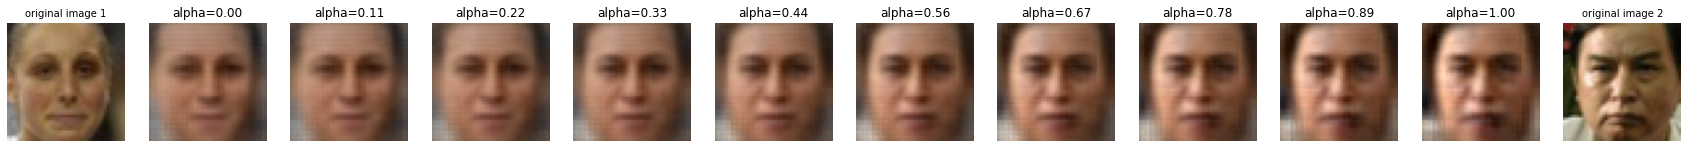

In [29]:
sample_index = random.sample(range(1, len(data)), 2)
morphBetweenImages(data[sample_index[0]],data[sample_index[1]],10)


### 1.5 Attribute shift (10 points)

In [33]:
# Don't change this helper function!
def PlotAttributeShift(data2,pic_output):
    sample_index = random.sample(range(1, len(data2)), 16)

    fig, axs = plt.subplots(4, 8)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    for i in range(4):
        for j in range(4):
            axs[i, 2*j].imshow(data2[sample_index[4*i+j], :, :, :])
            axs[i, 2*j].axis('off')
            axs[i, 2*j+1].imshow(np.clip(pic_output[sample_index[4*i+j]],0,1))
            axs[i, 2*j+1].axis('off')

In [34]:
def AttributeShift(encoder_model,decoder_model,data1,data2):
    # Your code here
    z1 = encoder_model.predict(data1)
    z2 = encoder_model.predict(data2)
    delta = np.mean(z1, axis=0) - np.mean(z2, axis=0)
    pic_output = decoder_model.predict(z2 + delta)
    return pic_output